<a href="https://colab.research.google.com/github/AkshatShrinate/Zeotap/blob/main/Akshat_Shrinate_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score



In [42]:
#Uploaded the files in a public github reporsitory and then imported the file into Google Colab
customer_dataset = pd.read_csv('https://raw.githubusercontent.com/AkshatShrinate/Zeotap/main/Datasets/Customers.csv')
Products_dataset = pd.read_csv('https://raw.githubusercontent.com/AkshatShrinate/Zeotap/main/Datasets/Products.csv')
Transactions_dataset = pd.read_csv('https://raw.githubusercontent.com/AkshatShrinate/Zeotap/main/Datasets/Transactions.csv')


In [3]:
#checking for missing values
print(customer_dataset.isnull().sum())
print(Products_dataset.isnull().sum())
print(Transactions_dataset.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [90]:
#checking for duplicated data
print(customer_dataset.duplicated().sum())
print(Products_dataset.duplicated().sum())
print(Transactions_dataset.duplicated().sum())

0
0
0


The Datasets are Consumers, Products and Transactions. Consumers are uniquely identifiable by the Consumer ID, while the products are identifiable using Product ID. Thus, using these IDs, we can merge the datasets to achieve a combined dataset with values corresponding for each Customer and each Transaction

In [91]:
transactions_customers = Transactions_dataset.merge(customer_dataset, on='CustomerID', how='inner')
merged_data = transactions_customers.merge(Products_dataset, on='ProductID', how='inner')
new_order = ['TransactionDate', 'CustomerID', 'CustomerName', 'Region',
             'ProductID', 'ProductName', 'Category', 'Price_x', 'Quantity', 'TotalValue','TransactionID','SignupDate' ]
# Reorder columns
new_dataset = merged_data[new_order]
new_dataset=new_dataset.sort_values(by="CustomerID") #the sorting is done based on CustomerID
new_dataset.head()

,TransactionDate,CustomerID,CustomerName,Region,ProductID,ProductName,Category,Price_x,Quantity,TotalValue,TransactionID,SignupDate
442,2024-09-17 9:01:18,C0001,Lawrence Carroll,South America,P022,HomeSense Wall Art,Home Decor,137.54,3,412.62,T00932,2022-07-10
724,2024-05-07 3:11:44,C0001,Lawrence Carroll,South America,P083,ActiveWear Smartwatch,Electronics,455.72,2,911.44,T00445,2022-07-10
135,2024-01-19 3:12:55,C0001,Lawrence Carroll,South America,P054,SoundWave Cookbook,Books,57.30,2,114.60,T00015,2022-07-10
776,2024-11-02 17:04:16,C0001,Lawrence Carroll,South America,P029,TechPro Headphones,Electronics,433.64,3,1300.92,T00436,2022-07-10
546,2024-04-08 0:01:00,C0001,Lawrence Carroll,South America,P096,SoundWave Headphones,Electronics,307.47,2,614.94,T00085,2022-07-10


In [92]:
new_dataset.rename(columns={'Price_x': 'Product_Price'}, inplace=True)  #the renaming of the Column is done to Product_Price
new_dataset.head()

,TransactionDate,CustomerID,CustomerName,Region,ProductID,ProductName,Category,Product_Price,Quantity,TotalValue,TransactionID,SignupDate
442,2024-09-17 9:01:18,C0001,Lawrence Carroll,South America,P022,HomeSense Wall Art,Home Decor,137.54,3,412.62,T00932,2022-07-10
724,2024-05-07 3:11:44,C0001,Lawrence Carroll,South America,P083,ActiveWear Smartwatch,Electronics,455.72,2,911.44,T00445,2022-07-10
135,2024-01-19 3:12:55,C0001,Lawrence Carroll,South America,P054,SoundWave Cookbook,Books,57.30,2,114.60,T00015,2022-07-10
776,2024-11-02 17:04:16,C0001,Lawrence Carroll,South America,P029,TechPro Headphones,Electronics,433.64,3,1300.92,T00436,2022-07-10
546,2024-04-08 0:01:00,C0001,Lawrence Carroll,South America,P096,SoundWave Headphones,Electronics,307.47,2,614.94,T00085,2022-07-10


Feature Engineering is used to identify similar customers who might be grouped together. Using the new_dataset, a few parameters are identified to identify Customers who are different from other customers. Thus, a Lookalike model can be built based on these parameters.

Identifed Parameteres include :

1) Total transactions from each customer

2) Total spending by each customer

3) The Average spending by each customer

4) The Top Category for each customer

5) Duration for which the customer is active

6) Region of each customer
Using these parameters, cluster segmentation is done on the costumers_records dataset

In [93]:
'''1) Total transactions from each customer'''
# Count total transactions per customer
customer_records = Transactions_dataset.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_records.columns = ['CustomerID', 'TotalTransactions']

# Display the first few rows
print(customer_records.head())

  CustomerID  TotalTransactions
0      C0001                  5
1      C0002                  4
2      C0003                  4
3      C0004                  8
4      C0005                  3


In [94]:
'''2) Total spending by each customer'''
customer_spending =Transactions_dataset.groupby('CustomerID')['Price'].sum().reset_index()
customer_spending.columns = ['CustomerID', 'TotalSpending']
customer_records["TotalSpending"]=customer_spending["TotalSpending"]  #adding it to the customer_records dataset
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending
0,C0001,5,1391.67
1,C0002,4,835.68
2,C0003,4,782.83
3,C0004,8,1925.09
4,C0005,3,874.81


In [95]:
'''3) The Average spending by each customer'''
customer_records["AvgSpending"]=customer_records['TotalSpending']/customer_records['TotalTransactions']
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending
0,C0001,5,1391.67,278.334000
1,C0002,4,835.68,208.920000
2,C0003,4,782.83,195.707500
3,C0004,8,1925.09,240.636250
4,C0005,3,874.81,291.603333


In [96]:
'''4) The Top Category of product bought by each customer'''
#First group the transactions by customer ID then group orders made by each customer by using the category to get a total count of each category for a user
top_category = new_dataset.groupby(['CustomerID', 'Category'])['TransactionID'].count().reset_index()
'''Now sorting is done by Customer ID in ASC order then by number of transactions for each category in descending order'''
top_category = top_category.sort_values(['CustomerID', 'TransactionID'], ascending=[True, False])
top_category.head()

,CustomerID,Category,TransactionID
1,C0001,Electronics,3
0,C0001,Books,1
2,C0001,Home Decor,1
3,C0002,Clothing,2
4,C0002,Home Decor,2


In [97]:
# We have received the transactions of each user in each category but we want only the top most one as it represents the top most category for each user
top_category = top_category.drop_duplicates(subset=['CustomerID'], keep='first')[['CustomerID', 'Category']]
top_category.columns = ['CustomerID', 'TopCategory']
print(top_category.head())

   CustomerID  TopCategory
1       C0001  Electronics
3       C0002     Clothing
7       C0003   Home Decor
8       C0004        Books
11      C0005  Electronics


In [98]:
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending
0,C0001,5,1391.67,278.334000
1,C0002,4,835.68,208.920000
2,C0003,4,782.83,195.707500
3,C0004,8,1925.09,240.636250
4,C0005,3,874.81,291.603333


In [99]:
'''5) Duration for which the customer is active: Calculated using the Signup Date column'''
customer_duration = customer_dataset[['CustomerID', 'SignupDate']]
customer_duration['SignupDate'] = pd.to_datetime(customer_duration['SignupDate'])
customer_duration['Duration_of_Activity'] = (pd.to_datetime('today') - customer_duration['SignupDate']).dt.days #to calculate count of days from Signup Date till today
customer_records=customer_records.merge(customer_duration,on='CustomerID',how='inner') #merging it to the customer_records dataset
customer_records.head()

<ipython-input-99-fbf869f8a337>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_duration['SignupDate'] = pd.to_datetime(customer_duration['SignupDate'])
<ipython-input-99-fbf869f8a337>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_duration['Duration_of_Activity'] = (pd.to_datetime('today') - customer_duration['SignupDate']).dt.days #to calculate count of days from Signup Date till today


,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity
0,C0001,5,1391.67,278.334000,2022-07-10,938
1,C0002,4,835.68,208.920000,2022-02-13,1085
2,C0003,4,782.83,195.707500,2024-03-07,332
3,C0004,8,1925.09,240.636250,2022-10-09,847
4,C0005,3,874.81,291.603333,2022-08-15,902


In [100]:
'''6) Region of each customer: To find this, One Hot Encoding is done over the Region column'''
OHE=OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
ohe=OHE.fit_transform(new_dataset[['Region']]).astype(int)
new_dataset = pd.concat([new_dataset, ohe], axis=1)
# Drop the original Region column
new_dataset.drop(columns=['Region'], inplace=True)
new_dataset.head()

,TransactionDate,CustomerID,CustomerName,ProductID,ProductName,Category,Product_Price,Quantity,TotalValue,TransactionID,SignupDate,Region_Asia,Region_Europe,Region_North America,Region_South America
442,2024-09-17 9:01:18,C0001,Lawrence Carroll,P022,HomeSense Wall Art,Home Decor,137.54,3,412.62,T00932,2022-07-10,0,0,0,1
724,2024-05-07 3:11:44,C0001,Lawrence Carroll,P083,ActiveWear Smartwatch,Electronics,455.72,2,911.44,T00445,2022-07-10,0,0,0,1
135,2024-01-19 3:12:55,C0001,Lawrence Carroll,P054,SoundWave Cookbook,Books,57.30,2,114.60,T00015,2022-07-10,0,0,0,1
776,2024-11-02 17:04:16,C0001,Lawrence Carroll,P029,TechPro Headphones,Electronics,433.64,3,1300.92,T00436,2022-07-10,0,0,0,1
546,2024-04-08 0:01:00,C0001,Lawrence Carroll,P096,SoundWave Headphones,Electronics,307.47,2,614.94,T00085,2022-07-10,0,0,0,1


In [101]:
#Similarly now that we have verified the region column's encoding we add it to the customer_records dataset
region_encoded_dataset = new_dataset[['CustomerID'] + list(ohe.columns)]
customer_records = customer_records.merge(region_encoded_dataset, on='CustomerID', how='left')
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1
1,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1
2,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1
3,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1
4,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1


In [102]:
# Merge TopCategory into customer_records using CustomerID
customer_records = customer_records.merge(top_category, on='CustomerID', how='left')
# Display the first few rows to verify the merge
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory
0,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1,Electronics
1,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1,Electronics
2,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1,Electronics
3,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1,Electronics
4,C0001,5,1391.67,278.334,2022-07-10,938,0,0,0,1,Electronics


In [103]:
customer_records = customer_records.drop_duplicates(subset=['CustomerID'], keep='first')
# Display the cleaned dataset
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory
0,C0001,5,1391.67,278.334000,2022-07-10,938,0,0,0,1,Electronics
5,C0002,4,835.68,208.920000,2022-02-13,1085,1,0,0,0,Clothing
9,C0003,4,782.83,195.707500,2024-03-07,332,0,0,0,1,Home Decor
13,C0004,8,1925.09,240.636250,2022-10-09,847,0,0,0,1,Books
21,C0005,3,874.81,291.603333,2022-08-15,902,1,0,0,0,Electronics


In [104]:
OHE=OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
ohe=OHE.fit_transform(customer_records[['TopCategory']]).astype(int)
customer_records = pd.concat([customer_records, ohe], axis=1)

# Drop the original Region column
customer_records.drop(columns=['TopCategory'], inplace=True)
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor
0,C0001,5,1391.67,278.334000,2022-07-10,938,0,0,0,1,0,0,1,0
5,C0002,4,835.68,208.920000,2022-02-13,1085,1,0,0,0,0,1,0,0
9,C0003,4,782.83,195.707500,2024-03-07,332,0,0,0,1,0,0,0,1
13,C0004,8,1925.09,240.636250,2022-10-09,847,0,0,0,1,1,0,0,0
21,C0005,3,874.81,291.603333,2022-08-15,902,1,0,0,0,0,0,1,0


In [105]:
print(customer_records.max())

CustomerID                               C0200
TotalTransactions                           11
TotalSpending                          3857.06
AvgSpending                             497.76
SignupDate                 2024-12-28 00:00:00
Duration_of_Activity                      1107
Region_Asia                                  1
Region_Europe                                1
Region_North America                         1
Region_South America                         1
TopCategory_Books                            1
TopCategory_Clothing                         1
TopCategory_Electronics                      1
TopCategory_Home Decor                       1
dtype: object



Normalisation of Data: A Min-Max approach is preferred in this situation and the value of the columns is reduced between 0 and 1.

In [106]:
# Create a copy to preserve the original dataset
customer_records_scaled = customer_records.copy()
columns_to_scale = customer_records_scaled.columns.difference(['CustomerID', 'SignupDate'])
# Dropping the 'CustomerID' and 'SignupDate' from the columns_to_scale as they contain non-numeric data
scaler = MinMaxScaler() # Initialize MinMaxScaler
customer_records_scaled[columns_to_scale] = scaler.fit_transform(customer_records_scaled[columns_to_scale])
customer_records_scaled.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor
0,C0001,0.4,0.353913,0.519414,2022-07-10,0.842204,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,C0002,0.3,0.208209,0.367384,2022-02-13,0.979458,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,C0003,0.3,0.194359,0.338446,2024-03-07,0.276377,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13,C0004,0.7,0.493703,0.436848,2022-10-09,0.757236,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21,C0005,0.2,0.218463,0.548476,2022-08-15,0.808590,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


For Clustering Segmentation : K Means Clustering is chosen
TO identify the best possible number of elements in a cluster, a visual plot is done.
For K means Clustering, metrics used are:

1) DB Score : The DB Score measures how well clusters are separated and how compact they are. Lower DB score is better as it represents that the clusters are away from each other

2)Silhouette Score: It checks how well each point fits into its cluster. It compares how close a point is to others in its cluster versus points in the nearest different cluster.The score ranges from -1 to 1. Higher Silhouette score is preferred.


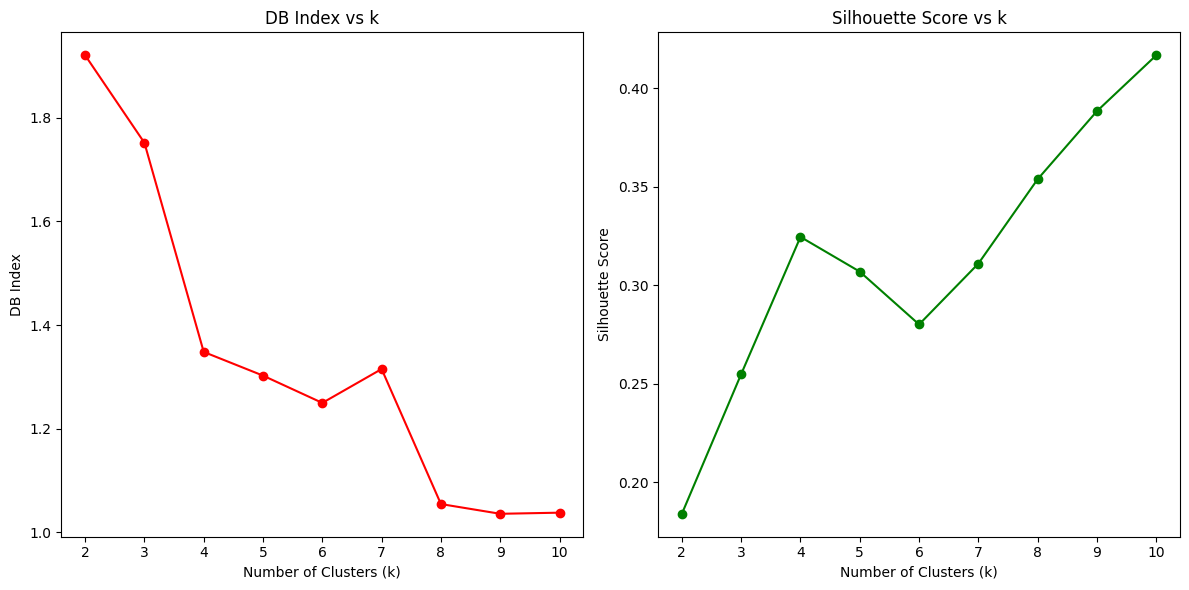

In [107]:
db_indexes = [] #empty list are created
silhouette_scores = []
k_values = range(2, 11)  # k ranges from 2 to 10 & the final value is not included in the range() function

for k in k_values:  #to iterate for each value in k_value
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_records_scaled['Cluster'] = kmeans.fit_predict(customer_records_scaled[columns_to_scale])
    # Calculate DB Index and Silhouette Score for each k
    db_index = davies_bouldin_score(customer_records_scaled[columns_to_scale], customer_records_scaled['Cluster'])
    silhouette = silhouette_score(customer_records_scaled[columns_to_scale], customer_records_scaled['Cluster'])
    db_indexes.append(db_index) #to add the value to the list
    silhouette_scores.append(silhouette)
# Plot the DB Index and Silhouette Score to better understand visually which value of k can be taken
plt.figure(figsize=(12, 6))
# Plot DB Index
plt.subplot(1, 2, 1)
plt.plot(k_values, db_indexes, marker='o', color='red')
plt.title('DB Index vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


THe loweest DB Score is at cluster value k=10

The Highest Silhouette Score is at cluster value k=10

thus 10 is taken as the most optimum value of number of elements in a cluster group

In [108]:
k_10_db_index = db_indexes[8]
k_10_silhouette_score = silhouette_scores[8]

print(f"For k = 10 -")
print(f"DB Index: {k_10_db_index}")
print(f"Silhouette Score: {k_10_silhouette_score}")

For k = 10 -
DB Index: 1.0380185589248452
Silhouette Score: 0.41667218112638393


In [109]:
kmeans = KMeans(n_clusters=10, random_state=42)
customer_records_scaled['Cluster'] = kmeans.fit_predict(customer_records_scaled[columns_to_scale]) #the CLuster column represents the assigned cluster number
# Print the first few rows of the dataset with the assigned cluster number
customer_records_scaled.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor,Cluster
0,C0001,0.4,0.353913,0.519414,2022-07-10,0.842204,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
5,C0002,0.3,0.208209,0.367384,2022-02-13,0.979458,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
9,C0003,0.3,0.194359,0.338446,2024-03-07,0.276377,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
13,C0004,0.7,0.493703,0.436848,2022-10-09,0.757236,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5
21,C0005,0.2,0.218463,0.548476,2022-08-15,0.808590,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3


In [111]:
# Number of customers in each cluster
cluster_counts = customer_records_scaled['Cluster'].value_counts()
print("Cluster Number | Number of customers")
print(cluster_counts)

'''Cluster centroids are the central points of a cluster in clustering algorithms like K-Means. They represent the "average" or the most typical point in each cluster.'''
centroids = kmeans.cluster_centers_
centroids_dataset = pd.DataFrame(centroids, columns=columns_to_scale)
print("Cluster Centroids:")
centroids_dataset

Cluster Number | Number of customers
Cluster
4    35
3    24
7    23
2    21
5    21
9    19
0    17
1    16
8    14
6     9
Name: count, dtype: int64
Cluster Centroids:


,AvgSpending,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor,TotalSpending,TotalTransactions
0,0.507165,0.535069,-2.775558e-17,1.000000e+00,8.326673e-17,0.000000,1.000000e+00,0.000000e+00,0.000000e+00,8.326673e-17,0.326033,0.382353
1,0.515243,0.594246,-2.775558e-17,0.000000e+00,8.326673e-17,1.000000,-1.110223e-16,0.000000e+00,1.000000e+00,8.326673e-17,0.351690,0.393750
2,0.453821,0.424125,3.809524e-01,0.000000e+00,2.775558e-17,0.619048,-1.110223e-16,-5.551115e-17,-5.551115e-17,1.000000e+00,0.277029,0.323810
3,0.536775,0.500195,1.000000e+00,0.000000e+00,-2.775558e-17,0.000000,5.416667e-01,-1.110223e-16,4.583333e-01,1.387779e-16,0.376357,0.437500
4,0.481857,0.509884,3.428571e-01,1.110223e-16,4.000000e-01,0.257143,1.110223e-16,1.000000e+00,-1.942890e-16,1.387779e-16,0.331806,0.400000
5,0.536479,0.576586,2.775558e-17,0.000000e+00,2.775558e-17,1.000000,1.000000e+00,-5.551115e-17,-5.551115e-17,1.110223e-16,0.406208,0.461905
6,0.505474,0.213819,-2.775558e-17,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.301978,0.355556
7,0.523884,0.445500,5.551115e-17,0.000000e+00,1.000000e+00,0.000000,6.956522e-01,-1.110223e-16,-1.110223e-16,3.043478e-01,0.416568,0.486957
8,0.493301,0.512738,0.000000e+00,1.000000e+00,8.326673e-17,0.000000,-5.551115e-17,0.000000e+00,0.000000e+00,1.000000e+00,0.316026,0.342857
9,0.504264,0.490147,-2.775558e-17,1.000000e+00,5.551115e-17,0.000000,-1.110223e-16,5.263158e-01,4.736842e-01,1.110223e-16,0.336427,0.373684


Principal Component Analysis: A way to better understand the clustering segmentation. The multiple columns in the dataset are converted into a 2 column axis to plot a graph to visualize the clusters.

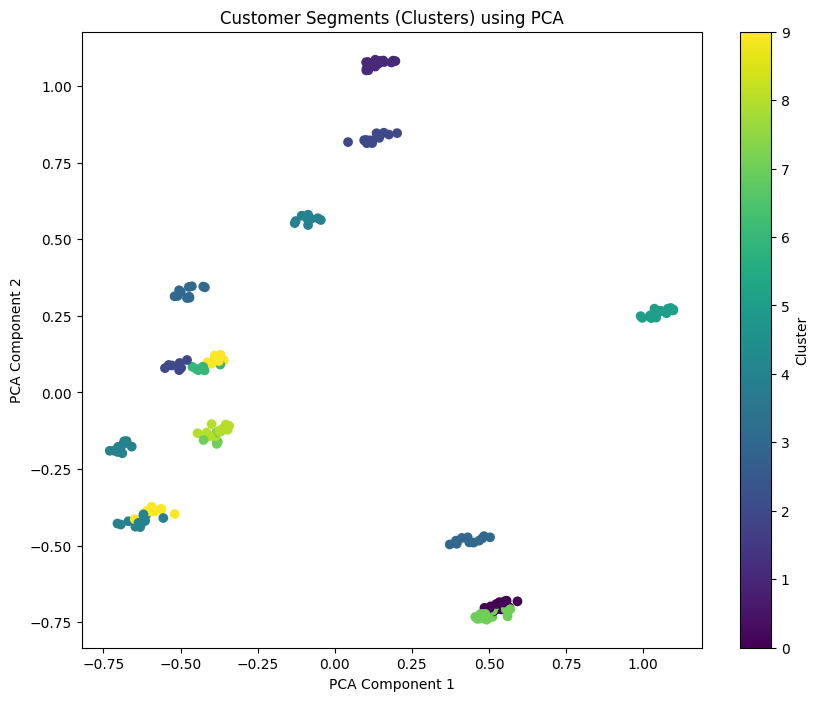

In [112]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_records_scaled[columns_to_scale])

# Add the PCA results to the dataset
customer_records_scaled['PCA1'] = pca_result[:, 0]
customer_records_scaled['PCA2'] = pca_result[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(customer_records_scaled['PCA1'], customer_records_scaled['PCA2'], c=customer_records_scaled['Cluster'], cmap='viridis')
plt.title('Customer Segments (Clusters) using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [113]:
# Group by the cluster and calculate the mean of each feature in the cluster
cluster_analysis = customer_records_scaled.groupby('Cluster')[columns_to_scale].mean()
print("Cluster Analysis (Mean Values for Each Feature):")
cluster_analysis


Cluster Analysis (Mean Values for Each Feature):


,AvgSpending,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor,TotalSpending,TotalTransactions
Cluster,,,,,,,,,,,,
0,0.507165,0.535069,0.000000,1.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.326033,0.382353
1,0.515243,0.594246,0.000000,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.351690,0.393750
2,0.453821,0.424125,0.380952,0.0,0.0,0.619048,0.000000,0.000000,0.000000,1.000000,0.277029,0.323810
3,0.536775,0.500195,1.000000,0.0,0.0,0.000000,0.541667,0.000000,0.458333,0.000000,0.376357,0.437500
4,0.481857,0.509884,0.342857,0.0,0.4,0.257143,0.000000,1.000000,0.000000,0.000000,0.331806,0.400000
5,0.536479,0.576586,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.406208,0.461905
6,0.505474,0.213819,0.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.301978,0.355556
7,0.523884,0.445500,0.000000,0.0,1.0,0.000000,0.695652,0.000000,0.000000,0.304348,0.416568,0.486957
8,0.493301,0.512738,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.316026,0.342857


In [114]:
customer_records['Cluster'] = customer_records_scaled['Cluster']


In [115]:
customer_records.head()

,CustomerID,TotalTransactions,TotalSpending,AvgSpending,SignupDate,Duration_of_Activity,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor,Cluster
0,C0001,5,1391.67,278.334000,2022-07-10,938,0,0,0,1,0,0,1,0,1
5,C0002,4,835.68,208.920000,2022-02-13,1085,1,0,0,0,0,1,0,0,4
9,C0003,4,782.83,195.707500,2024-03-07,332,0,0,0,1,0,0,0,1,2
13,C0004,8,1925.09,240.636250,2022-10-09,847,0,0,0,1,1,0,0,0,5
21,C0005,3,874.81,291.603333,2022-08-15,902,1,0,0,0,0,0,1,0,3
